In [12]:
import numpy as np
import plot
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches

In [13]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

rc('font',**{'family':'serif'})
rc('text', usetex=True)

In [14]:
ndim = 3
nwaves = 3

In [15]:
HM_data_EL_8 = np.loadtxt('3D_historymatch_ellipsoid.txt').reshape((nwaves*5000,4))
HM_data_EL_12 = np.loadtxt('3D_historymatch_ellipsoid_12z.txt').reshape((nwaves*5000,4))
HM_data_EL_test = np.loadtxt('data/3D_historymatch_ellipsoid_8z_test.txt').reshape((nwaves*5000,4))
HM_data_HC = np.loadtxt('3D_historymatch_hypercube.txt').reshape((nwaves*5000,4))

analytic_mean = np.loadtxt("3D_analytic_mean.txt").reshape(3,)
analytic_cov = np.loadtxt("3D_analytic_cov.txt").reshape(3,3)
H = analytic_cov

In [16]:
final_wave_EL_8 = HM_data_EL_8[(nwaves-1)*5000:]
final_wave_EL_12 = HM_data_EL_12[(nwaves-1)*5000:]
final_wave_EL_test = HM_data_EL_test[(nwaves-1)*5000:]

final_wave_HC = HM_data_HC[(nwaves-1)*5000:]

In [17]:
theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)
parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)

In [18]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)

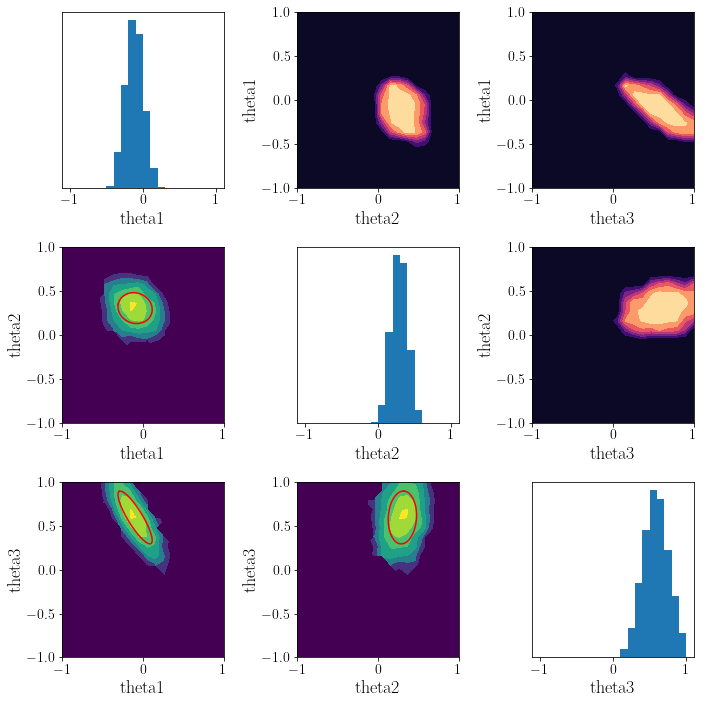

In [19]:
fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))

plot.plotcorner(final_wave_EL_8, parameter_bounds, 3, Fig=(fig,axes), labels=('theta1', 'theta2', 'theta3'))
get_cov_ellipse(np.array([[H[0,0], H[0,1]],[H[1,0], H[1,1]]]), [analytic_mean[0], analytic_mean[1]], 3, axes[1,0], 'red')
get_cov_ellipse(np.array([[H[0,0], H[0,2]],[H[2,0], H[2,2]]]), [analytic_mean[0], analytic_mean[2]], 3, axes[2,0], 'red')
get_cov_ellipse(np.array([[H[1,1], H[1,2]],[H[2,1], H[2,2]]]), [analytic_mean[1], analytic_mean[2]], 3, axes[2,1], 'red')

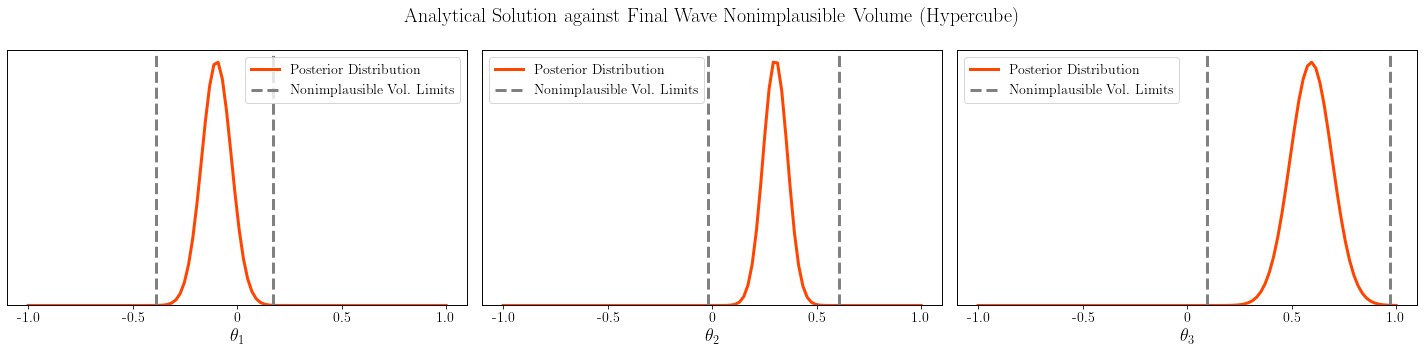

In [20]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']
#ax1_right = ax1.twinx()

for i in range(ndim):
    ax_right = axes[i].twinx()
    #plot.opticaldepth_1D(final_wave_HC, parameter_bounds[i], i, bins=50, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i], np.sqrt(H[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    
    min_theta = np.min(final_wave_HC[:,i])
    max_theta = np.max(final_wave_HC[:,i])
    ax_right.axvline(min_theta, color='grey', linestyle='--', linewidth=3, label=r'Nonimplausible Vol. Limits')
    ax_right.axvline(max_theta, color='grey', linestyle='--', linewidth=3)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i])
    #ax_right.tick_params(right=False)
    
    axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    handles, labels = ax_right.get_legend_handles_labels()
    #patch = mpatches.Patch(color='lightblue', label='Optical Depth')
    #handles.append(patch) 
    plt.legend(handles=handles, loc='best')
    
    
fig.suptitle('Analytical Solution against Final Wave Nonimplausible Volume (Hypercube)')
plt.tight_layout()

plt.savefig('3D_1Dplot.png', bbox_inches='tight', facecolor='white', transparent=False)


In [21]:
HM_cov_8 = np.cov(final_wave_EL_8.T[:-1])
HM_mean_8 = np.mean(final_wave_EL_8.T[:-1], axis=1)

HM_cov_12 = np.cov(final_wave_EL_12.T[:-1])
HM_mean_12 = np.mean(final_wave_EL_12.T[:-1], axis=1)

HM_cov_test = np.cov(final_wave_EL_test.T[:-1])
HM_mean_test = np.mean(final_wave_EL_test.T[:-1], axis=1)

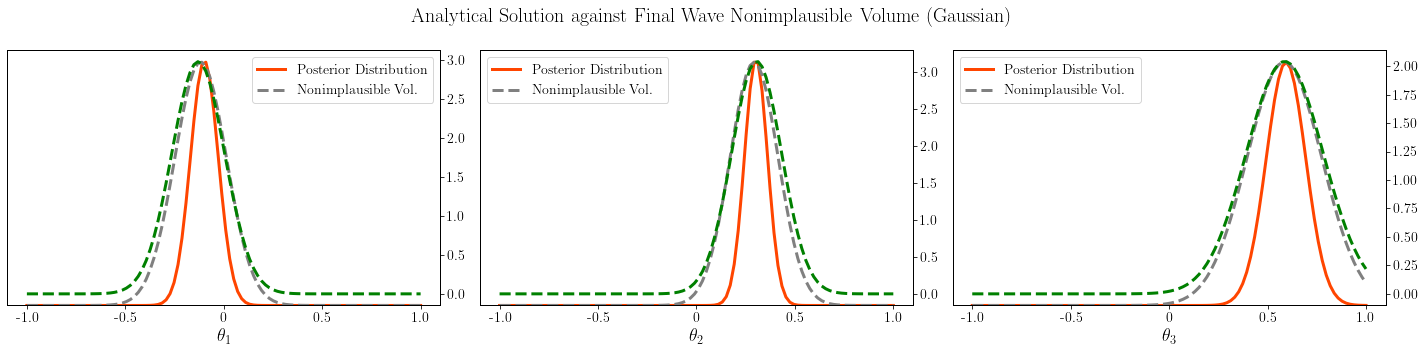

In [22]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']

for i in range(ndim):
    ax_right = axes[i].twinx()
    ax_right2 = axes[i].twinx()
    ax_right3 = axes[i].twinx()
    #plot.opticaldepth_1D(final_wave_EL, parameter_bounds[i], i, bins=80, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i], np.sqrt(H[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    ax_right2.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], HM_mean_8[i], np.sqrt(HM_cov_8[i,i])), color='grey', linestyle='--', linewidth=3, label='Nonimplausible Vol.')
    
    ax_right3.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], HM_mean_test[i], np.sqrt(HM_cov_test[i,i])), color='green', linestyle='--', linewidth=3, label='Nonimplausible Vol.')
    
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    ax_right2.set(yticklabels=[])  
    ax_right2.tick_params(right=False)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    ax_right2.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i])
    #ax_right.tick_params(right=False)
    
    axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    lines, labels = ax_right.get_legend_handles_labels()
    lines2, labels2 = ax_right2.get_legend_handles_labels()
    #lines.append(mpatches.Patch(color='lightblue'))
    #labels.append('Optical Depth')
    ax_right2.legend(lines + lines2, labels + labels2, loc=0)

    
    
fig.suptitle('Analytical Solution against Final Wave Nonimplausible Volume (Gaussian)')
plt.tight_layout()

plt.savefig('3D_1Dplot.png', bbox_inches='tight', facecolor='white', transparent=False)